In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kmapper as km
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings

# Cargar las bases de datos

In [3]:
tag2024 = pd.read_excel('TAGS/Consolidado Edenred 2024.xlsx', sheet_name='Detalle de Movimientos 2024')
tag2022 = pd.read_excel('TAGS/Edenred Consolidado 2022.xlsx', sheet_name='Detalle de Movimientos por Fact')
tag2023 = pd.read_excel('TAGS/Edenred Consolidado Diciembre 2023.xlsx', sheet_name='Detalle de Movimientos ')
tag2021 = pd.read_excel('TAGS/Edenred Fuel Consumption Consolidation 2021.xlsx', sheet_name='Detalle de Movimientos por Fact')

c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell AY8442 is marked as a date but the serial value 3655679 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell AZ8442 is marked as a date but the serial value 3611236 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell AY8443 is marked as a date but the serial value 3655679 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell AZ8443 is marked as a date but the serial value 3611236 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users

Concatenar los cuatro años de datos

In [4]:
tag = pd.concat([tag2021, tag2022, tag2023, tag2024], ignore_index=True)

Checar las columnas consistentes en todos los datasets

In [5]:
# check Common columns across all years
common_columns = set(tag2021.columns).intersection(tag2022.columns).intersection(tag2023.columns).intersection(tag2024.columns)
print(f'Columnas comunes: {common_columns}')
len(common_columns)
tag = tag[list(common_columns)]

Columnas comunes: {'No Estación Pemex', 'Folio', 'BL', 'Num Tarjeta', 'Observación', 'Importe Transacción', 'Respuesta', 'No Comprobante', 'RFC', 'Id Grupo Región', 'Cantidad Mercancía', 'Precio Unitario', 'Rendimiento Real', 'Hora Transacción', 'Month', 'Conductor', 'Importe Neto', 'Comision', 'Mercancía', 'KG C02', 'Fecha Transacción', 'Division', 'Placa', 'TON C02', 'Km Ant Transacción', 'Rendimiento', 'Id Región', 'Km Transacción', 'IVA', 'Id Conductor', 'Factura', 'IEPS', 'Identificador Vehículo', 'Num Serie', 'Número de Control', 'Vehículo', 'Cliente', 'Arboles', 'Subtotal', 'Recorrido', 'IVA %', 'Razón Social Afiliado', 'Serie', 'Id Mercancía'}


In [6]:
# Tamaño del dataset
print(f'Tamaño del dataset: {tag.shape[0]} filas y {tag.shape[1]} columnas')

Tamaño del dataset: 48769 filas y 44 columnas


Corregir inconsistencias y errores en la base de datos

In [7]:
# Corregir los valores que no están en el formato abreviado de mes
# Crear un diccionario para mapear los nombres de meses en diferentes formatos al formato abreviado en inglés
month_mapping = {
    'ene.': 'Jan', 'feb.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr', 'may.': 'May', 'jun.': 'Jun',
    'jul.': 'Jul', 'ago.': 'Aug', 'sep.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'dic.': 'Dec', 'Abr': 'Apr',
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Aug': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dec': 'Dec'
}

# Corregir los valores de la columna 'Month' utilizando el mapeo
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))

In [8]:
tag['Fecha Transacción'] = pd.to_datetime(tag['Fecha Transacción'], format='%d/%m/%Y', errors='coerce')
# Convertir la columna 'Hora Transacción' al formato datetime.time
tag['Hora Transacción'] = pd.to_datetime(tag['Hora Transacción'], format='%H:%M:%S', errors='coerce').dt.time

# Variables a analizar

El analisis correspondiente a por que se eligieron estas columnas estan detalladas en la etapa 2

In [9]:
# Definir las columnas que se desean conservar
columnsToKeep = [
       'Month', 'Id Región',
       'Division', 'BL', 'Identificador Vehículo', 'Vehículo', 'Placa', 
       'Num Tarjeta', 'Num Serie', 'Fecha Transacción', 'Hora Transacción', 
       'Id Mercancía', 'Mercancía', 'Km Ant Transacción', 
       'Km Transacción', 'Recorrido',
       'Importe Transacción', 'Cantidad Mercancía', 
       'KG C02', 'Arboles', 'Precio Unitario', 'Rendimiento', 
       'Rendimiento Real', 'Id Conductor',
       'Observación', 'Respuesta']

In [10]:
cuantitativas = ['Km Ant Transacción',
                'Km Transacción',
                'Recorrido',
                'Importe Transacción',
                'Cantidad Mercancía',
                'KG C02',
                'Arboles',
                'Precio Unitario',
                'Rendimiento',
                'Rendimiento Real']
cualitativas = ['Month',
                'Id Región',
                'Division',
                'BL',
                'Identificador Vehículo',
                'Vehículo',
                'Placa',
                'Num Tarjeta',
                'Num Serie',
                'Fecha Transacción',
                'Hora Transacción',
                'Id Mercancía',
                'Mercancía',
                'Id Conductor',
                'Observación',
                'Respuesta']

In [11]:
tag = tag[columnsToKeep]

# Limpieza de datos

In [12]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48769 entries, 0 to 48768
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   48769 non-null  object        
 1   Id Región               48764 non-null  object        
 2   Division                48769 non-null  object        
 3   BL                      48769 non-null  object        
 4   Identificador Vehículo  48769 non-null  object        
 5   Vehículo                48769 non-null  object        
 6   Placa                   48769 non-null  object        
 7   Num Tarjeta             48769 non-null  int64         
 8   Num Serie               48769 non-null  object        
 9   Fecha Transacción       48392 non-null  datetime64[ns]
 10  Hora Transacción        48355 non-null  object        
 11  Id Mercancía            48769 non-null  int64         
 12  Mercancía               48769 non-null  object

Nota: al quitar los nulos se pierden muchos datos (casi 10000 filas), para futuras pruebas, podemos quitar las variables cualitativas 'Id Conductor' y 'Observacion', que son las que tienen mas valores nulos, a ver si asi perdemos menos cantidad de datos

In [13]:
# Quitar valores nulos
tag = tag.dropna()

In [14]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37578 entries, 29 to 48267
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   37578 non-null  object        
 1   Id Región               37578 non-null  object        
 2   Division                37578 non-null  object        
 3   BL                      37578 non-null  object        
 4   Identificador Vehículo  37578 non-null  object        
 5   Vehículo                37578 non-null  object        
 6   Placa                   37578 non-null  object        
 7   Num Tarjeta             37578 non-null  int64         
 8   Num Serie               37578 non-null  object        
 9   Fecha Transacción       37578 non-null  datetime64[ns]
 10  Hora Transacción        37578 non-null  object        
 11  Id Mercancía            37578 non-null  int64         
 12  Mercancía               37578 non-null  object    

En el caso de las variables cuantitativas, revisar que los datos tengan sentido y que esten limpios y de buena calidad, observamos que:

- 'Recorrido' tiene valores negativos (imposible)
- 'Rendimiento real' tiene valores negativos (imposible)

In [15]:
tag[cuantitativas].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Km Ant Transacción,37578.0,143954.961041,469309.603878,0.000000e+00,40238.750000,91240.000000,140754.000000,9.850034e+06
Km Transacción,37578.0,146060.758449,477606.392761,0.000000e+00,40768.250000,91680.500000,141218.000000,9.850034e+06
Recorrido,37578.0,2105.797408,208627.994919,-9.750948e+06,145.000000,270.000000,427.000000,9.751982e+06
Importe Transacción,37578.0,2157.101542,2543.952332,2.319000e+01,1019.500000,1448.300000,1911.496777,2.434409e+04
Cantidad Mercancía,37578.0,95.939576,106.869957,1.000000e+00,48.130000,66.990000,86.535107,1.000000e+03
KG C02,37578.0,230.364156,258.324052,2.421000e+00,114.882502,160.285241,208.206000,2.421000e+03
Arboles,37578.0,15.357610,17.221603,1.614000e-01,7.658833,10.685683,13.880400,1.614000e+02
Precio Unitario,37578.0,22.073714,6.874690,2.005176e+00,20.690000,22.063592,22.990000,5.551263e+02
Rendimiento,37578.0,12.290816,3.190509,1.000000e-02,10.000000,14.000000,14.000000,2.434000e+01
Rendimiento Real,37578.0,-98.133212,19879.956258,-3.666055e+06,2.020000,4.510000,7.800000,5.414736e+05


In [16]:
# Revisar cuantos valores de 'Recorrido' son negativos
recorrido_negativos = tag[tag['Recorrido'] < 0]
print(f'Cantidad de recorridos negativos: {recorrido_negativos.shape[0]}')

Cantidad de recorridos negativos: 1701


In [17]:
# Revisar cuantos valores de 'Rendimiento Real' son negativos
rendimiento_real_negativos = tag[tag['Rendimiento Real'] < 0]
print(f'Cantidad de rendimientos reales negativos: {rendimiento_real_negativos.shape[0]}')

Cantidad de rendimientos reales negativos: 1681


In [18]:
# Drop the negative values
tag = tag[tag['Recorrido'] >= 0]
tag = tag[tag['Rendimiento Real'] >= 0]

Implementar un metodo de deteccion de outliers (en mi caso el z-score) y revisar nuevamente nuestra base de datos

In [19]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    print(f'Cantidad de outliers en {column}: {outliers.shape[0]}')

Cantidad de outliers en Km Ant Transacción: 231
Cantidad de outliers en Km Transacción: 270
Cantidad de outliers en Recorrido: 216
Cantidad de outliers en Importe Transacción: 1095
Cantidad de outliers en Cantidad Mercancía: 969
Cantidad de outliers en KG C02: 980
Cantidad de outliers en Arboles: 980
Cantidad de outliers en Precio Unitario: 81
Cantidad de outliers en Rendimiento: 332
Cantidad de outliers en Rendimiento Real: 155


In [20]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    # Drop the outliers
    tag = tag[abs(z_scores) <= 3]

In [21]:
tag[cuantitativas].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Km Ant Transacción,30060.0,97236.889621,77148.513012,0.000000,40347.500000,88881.000000,134529.500000,743251.000000
Km Transacción,30060.0,97647.127611,77152.828927,0.000000,40827.500000,89202.000000,134867.750000,747098.000000
Recorrido,30060.0,410.237991,1154.601738,0.000000,170.000000,277.000000,407.000000,34445.000000
Importe Transacción,30060.0,1356.272249,528.470274,23.740000,981.860248,1345.775871,1696.001788,3761.901359
Cantidad Mercancía,30060.0,62.747844,23.371466,1.000000,45.569022,62.482783,79.500000,141.600000
KG C02,30060.0,151.268274,56.502050,2.421000,109.667782,150.228429,191.524770,342.813600
Arboles,30060.0,10.084552,3.766803,0.161400,7.311185,10.015229,12.768318,22.854240
Precio Unitario,30060.0,21.634959,1.781632,4.143953,20.450000,21.945621,22.679966,42.117433
Rendimiento,30060.0,12.198066,2.982106,3.000000,10.000000,14.000000,14.000000,21.650000
Rendimiento Real,30060.0,7.942568,19.203166,0.000000,3.010000,5.040000,7.960000,359.350000


<Figure size 2000x2000 with 0 Axes>

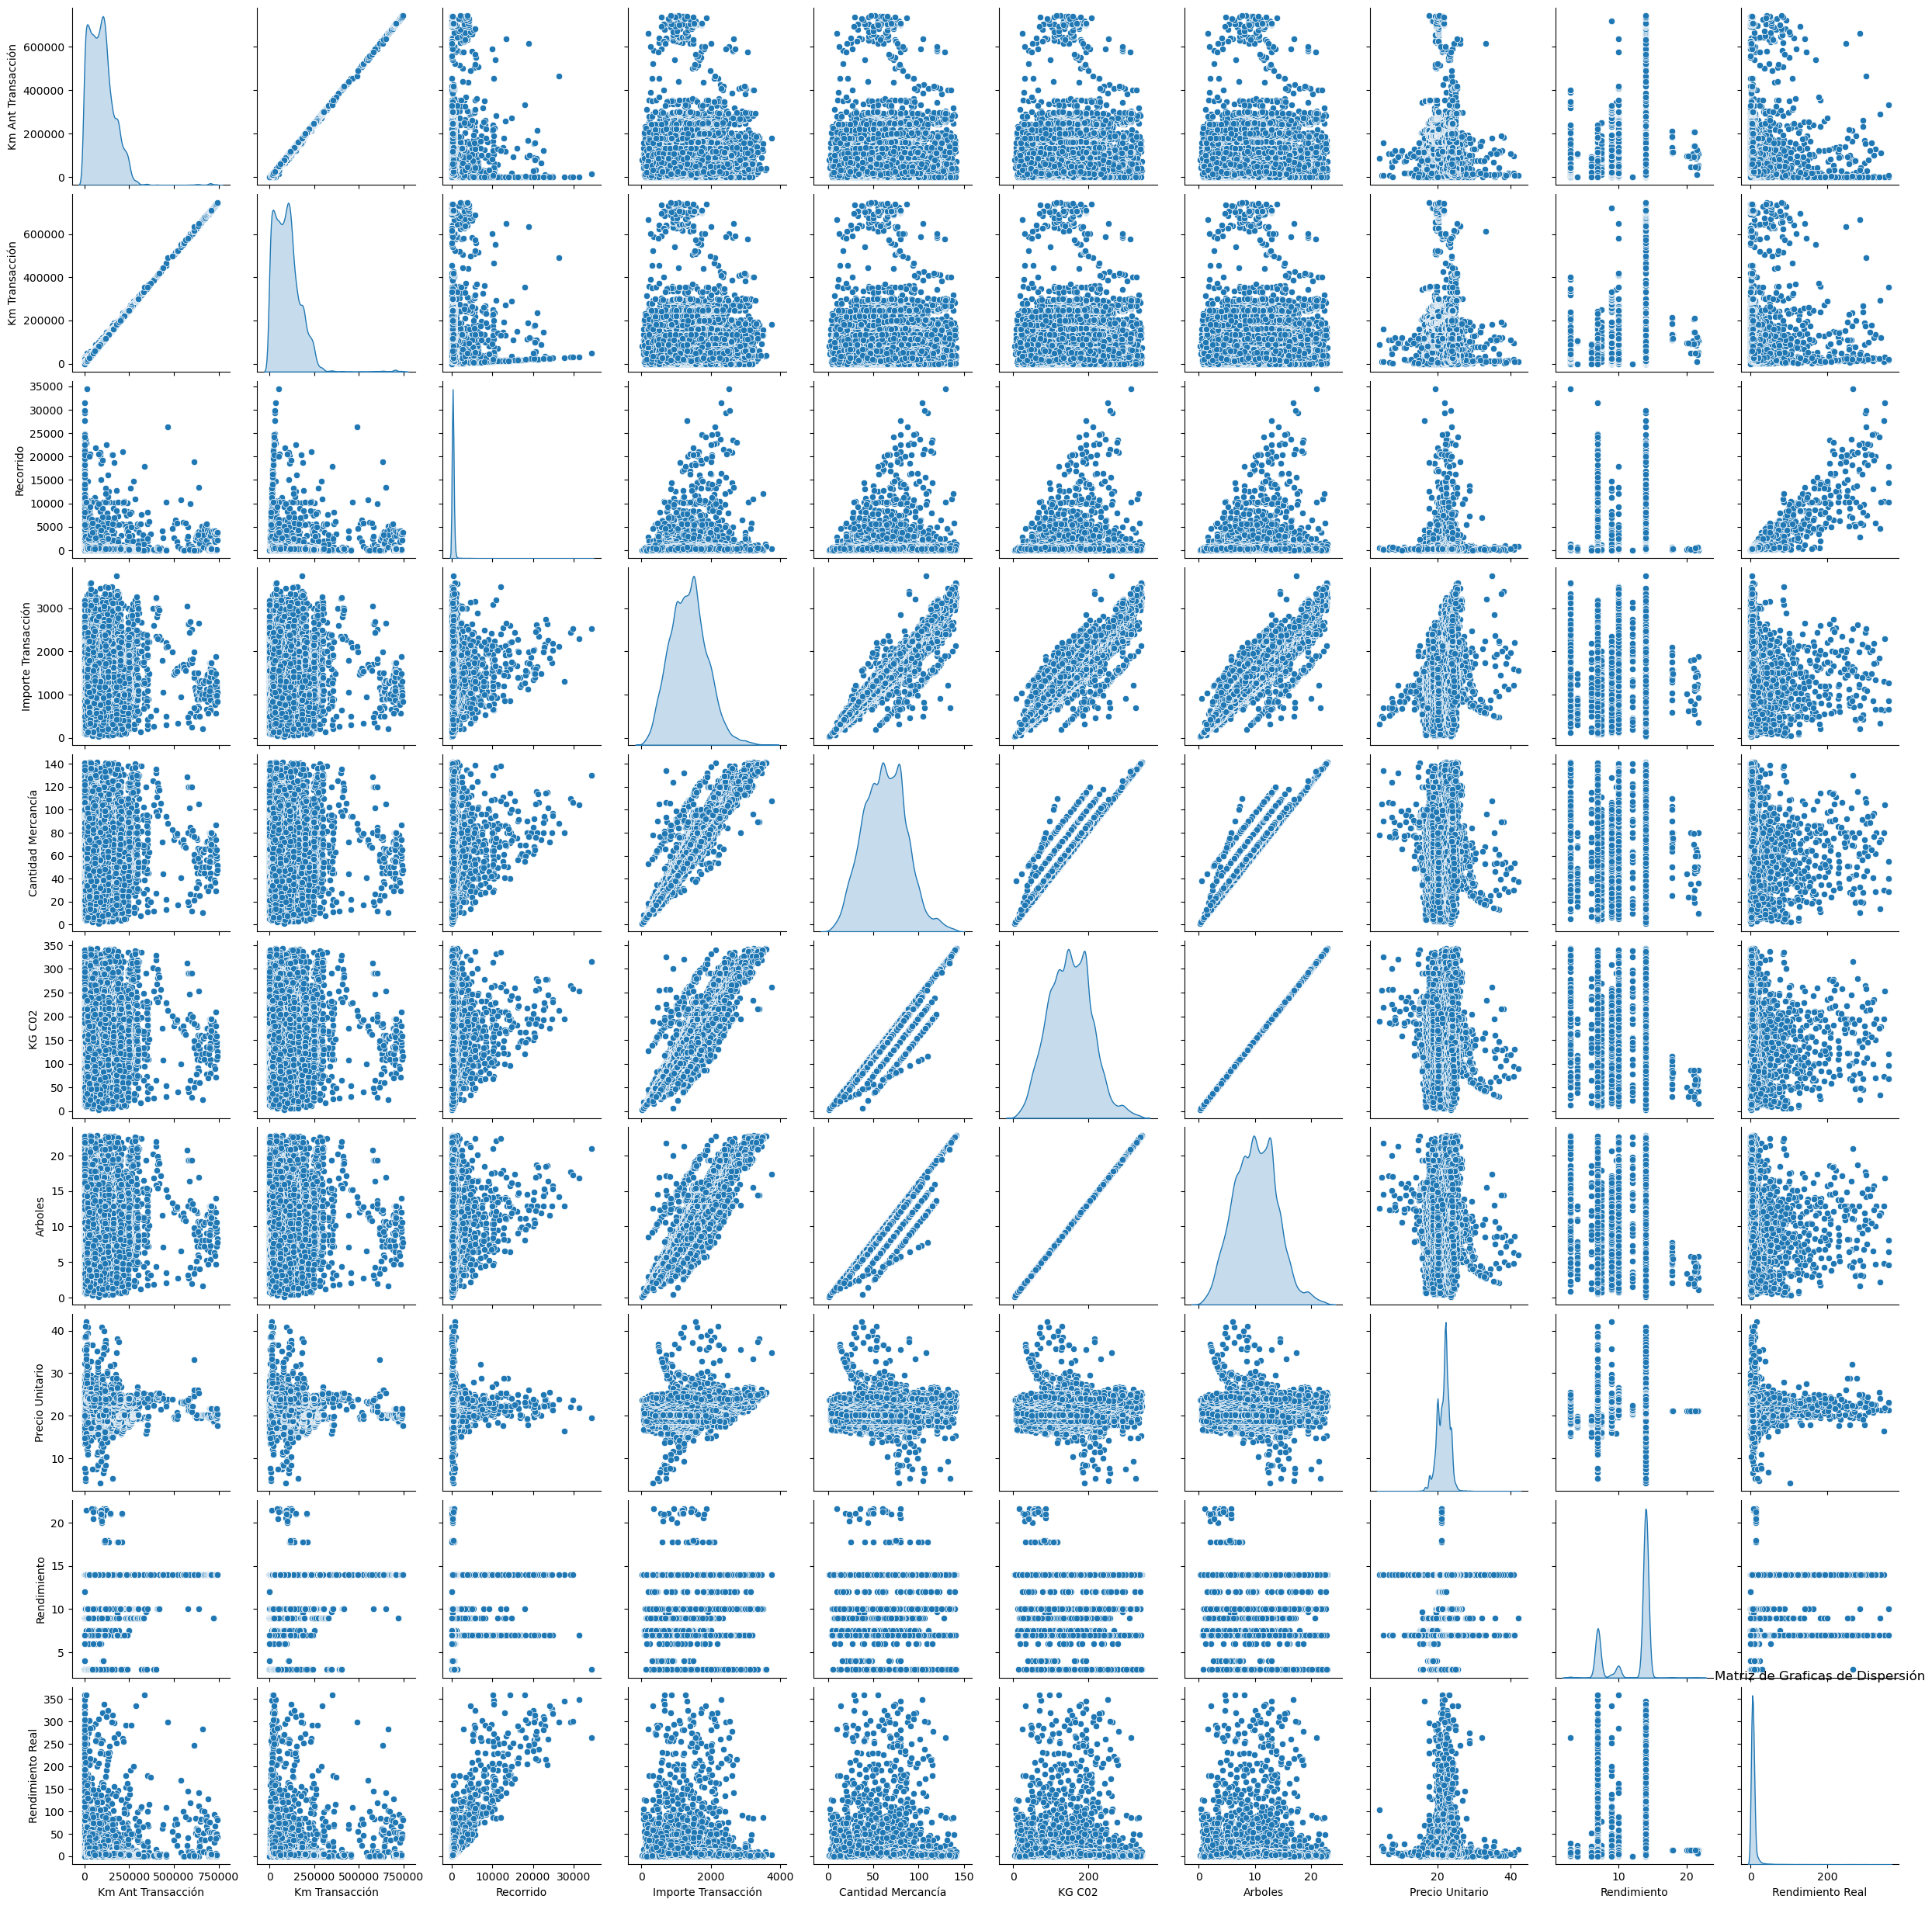

In [22]:
plt.figure(figsize=(20, 20))
sns.pairplot(tag[cuantitativas], diag_kind='kde')
plt.title('Matriz de Graficas de Dispersión')
plt.savefig('TAGS/Matriz de Graficas de Dispersión.png', dpi=300, bbox_inches='tight')
plt.show()

# Escalado de los datos

In [23]:
tag.reset_index(drop=True, inplace=True)
X = tag[cuantitativas].copy()
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

In [24]:
mapper = km.KeplerMapper()
lens = PCA(n_components=2).fit_transform(X_scaled) 

# Mapper

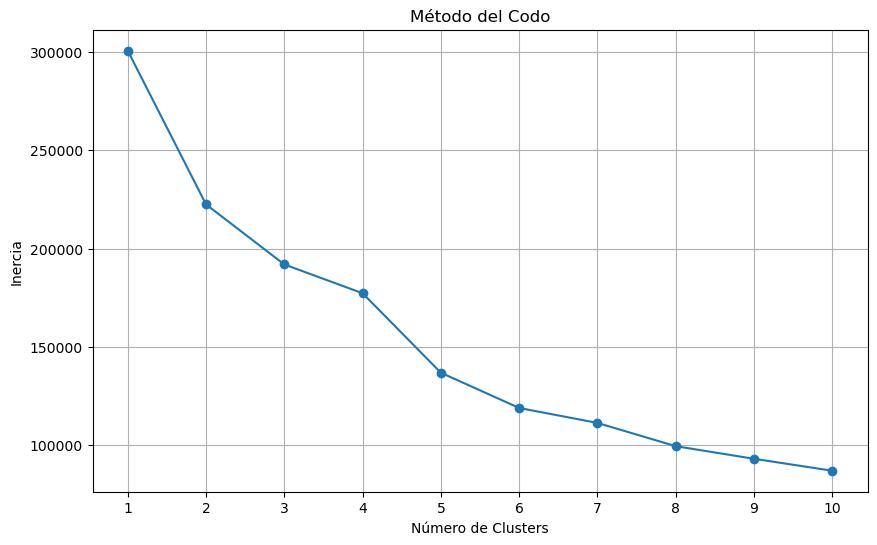

In [25]:
# Metodo del codo para determinar el número óptimo de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

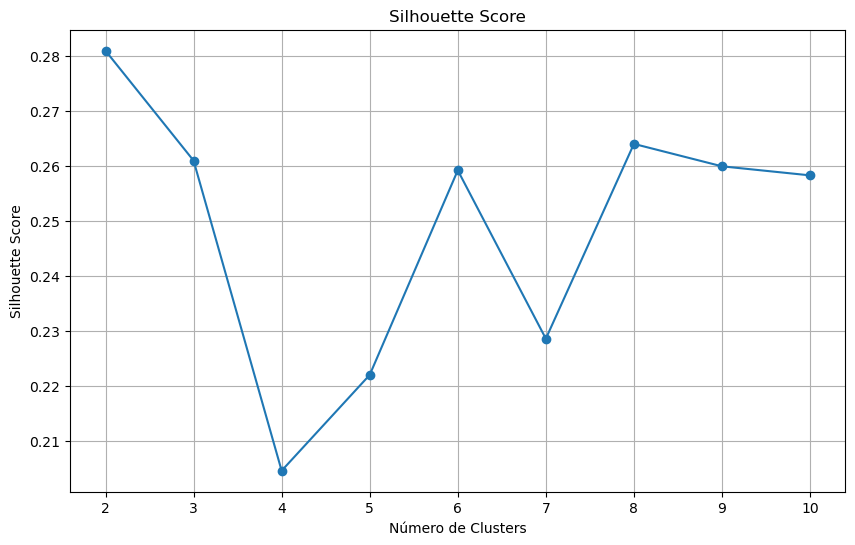

In [26]:
# Silhouette Score para determinar el número óptimo de clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [35]:
graph = mapper.map(
    lens,  # datos de entrada
    X_scaled,  # datos originales
    clusterer=KMeans(n_clusters=3, random_state=12),  # algoritmo de agrupamiento
    cover=km.Cover(n_cubes=5, perc_overlap=0.09),  # cubos y superposición
)

# Visualizar el grafo
html_output = mapper.visualize(
    graph,
    title="Mapper Problema 3",
    X = X.values,
    X_names = X.columns.tolist(),
    custom_tooltips=(
        tag['Identificador Vehículo']
    ),
    color_values=tag[['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real']],
    color_function_name=['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real'],
    node_color_function=['mean', 'max', 'min'],
    nbins=10,
    include_searchbar=True,
    include_min_intersection_selector=True,
    # color_values=skills['value_eur'],
    # color_function_name="Value in Euros",
)

# Guardar la visualización en un archivo HTML
with open('TAGS.html', 'w') as f:
    f.write(html_output)

c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jesus\anaconda3\envs\optimus\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn